In [1]:
import os
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim


In [3]:
# Read the training data from a CSV file
training_data_home = pd.read_csv('data/Train_Data/train_home_team_statistics_df.csv')
training_data_away = pd.read_csv('data/Train_Data/train_away_team_statistics_df.csv')
training_data_away_player = pd.read_csv('data/Train_Data/train_away_player_statistics_df.csv')
training_data_home_player = pd.read_csv('data/Train_Data/train_home_player_statistics_df.csv')
train_y = pd.read_csv('data/Train_Data/Y_train_supp.csv')


In [50]:
# treat the data

# Convert the training data to numpy arrays
training_data_home_np = training_data_home.iloc[:, 3:].values
training_data_away_np = training_data_away.iloc[:, 3:].values

# Normalize the columns of the training data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
training_data_home_np = scaler.fit_transform(training_data_home_np)
training_data_away_np = scaler.fit_transform(training_data_away_np)

# Replace NaN values with 0
training_data_home_np = np.nan_to_num(training_data_home_np)
training_data_away_np = np.nan_to_num(training_data_away_np)

# Convert the numpy arrays back to PyTorch tensors
train_data_home_t = torch.Tensor(training_data_home_np)
train_data_away_t = torch.Tensor(training_data_away_np)


train_data_total_t = torch.cat((train_data_home_t, train_data_away_t), 1)
train_y_total_t = torch.Tensor(train_y.iloc[:,1:].values)
train_y_total_t = torch.div(torch.clamp(train_y_total_t, -3, 3),3)

train_data_t, test_data_t, train_y_t, test_y_t = train_test_split(train_data_total_t, train_y_total_t, test_size=0.2, random_state=42)

#training_data_away_player_t = torch.Tensor(training_data_away_player.iloc[:, 3:].values)
#training_data_home_player_t = torch.Tensor(training_data_home_player.iloc[:, 3:].values)


In [47]:
output_size = 2*3+1 # classification with difference in goals [-3,3]

num_epochs = 100
batch_size = 128
input_size = 2*train_data_home_t.shape[1]

# Params for optimizer
learning_rate = 0.0001
learning_rate_step = 10
learning_rate_gamma = 1
weight_decay = 1e-3


In [57]:
# Define the network architecture
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        self.nn = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 128),
        )

        self.nn_output = nn.Sequential(
            nn.LeakyReLU(),
            nn.Linear(128, 1),
            nn.Tanh()
        )

    def forward(self, x):
        # Define the forward pass of your network
        logits = self.nn(x)
        return self.nn_output(logits)

# Create an instance of the neural network
model = NeuralNetwork()

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate,  weight_decay=weight_decay)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=learning_rate_step, gamma=learning_rate_gamma)


total_loss = []
accuracy = []
accuracy_test = []
# Train the network
for epoch in tqdm.tqdm(range(num_epochs)):
    # Forward pass
    ids = np.arange(len(train_data_t))
    np.random.shuffle(ids)
    current_loss = 0
    success = 0
    total = 0
    
    for i in range(0, len(ids), batch_size):
        # Get the batch of data
        batch_ids = ids[i:i+batch_size]
        batch_data = [train_data_t[j] for j in batch_ids]
        batch_labels = [train_y_t[j] for j in batch_ids]

        # Convert the batch data and labels to tensors
        batch_data = torch.stack(batch_data)
        batch_labels = torch.stack(batch_labels)

        # Forward pass
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)
        current_loss += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += len(outputs)
        for j in range(len(outputs)):
            k1 = outputs[j].item()
            k2 = batch_labels[j].item()
            if (k2>0.2 and k1>0.2) or (k2<=0.2 and k1<=0.2 and k2>=-0.2 and k1 >= 0.2) or (k2<-0.2 and k1<-0.2):
                success += 1

    accuracy.append(success/total)

    success = 0
    outputs = model(test_data_t)
    for i in range(len(test_data_t)):
        k1 = outputs[j].item()
        k2 = test_y_t[j].item()
        if (k2>0.2 and k1>0.2) or (k2<=0.2 and k1<=0.2 and k2>=-0.2 and k1 >= 0.2) or (k2<-0.2 and k1<-0.2):
                success += 1
    accuracy_test.append(success/len(test_data_t))

    total_loss.append(batch_size*current_loss/len(training_data_home))
    scheduler.step()



  0%|          | 0/100 [00:00<?, ?it/s]

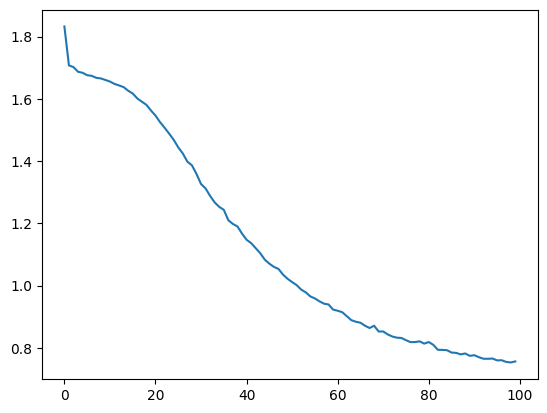

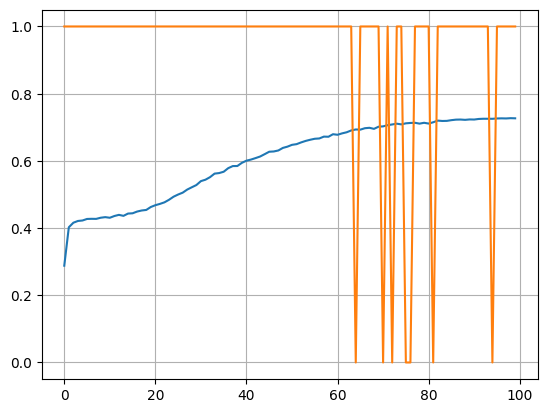

Training accuracy:  0.726681568786832
Test accuracy:  1.0


In [56]:
plt.figure()
plt.plot(total_loss)

plt.figure()
plt.grid()
plt.plot(accuracy, label="train")
plt.plot(accuracy_test, label="test")
plt.show()

print("Training accuracy: ", accuracy[-1])
print("Test accuracy: ", accuracy_test[-1])

In [1]:
# Read the testing data from a CSV file
test_data_home = pd.read_csv('data/Test_Data/test_home_team_statistics_df.csv')
test_data_away = pd.read_csv('data/Test_Data/test_away_team_statistics_df.csv')


NameError: name 'pd' is not defined

In [24]:
test_data_home.max().to_csv('data/test_home_stats.csv')

In [138]:
# treat the data

# Convert the training data to numpy arrays
test_data_home_np = test_data_home.iloc[:, 1:].values
test_data_away_np = test_data_away.iloc[:, 1:].values

# Normalize the columns of the training data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
test_data_home_np = scaler.fit_transform(test_data_home_np)
test_data_away_np = scaler.fit_transform(test_data_away_np)

# Replace NaN values with 0
test_data_home_np = np.nan_to_num(test_data_home_np)
test_data_away_np = np.nan_to_num(test_data_away_np)

# Convert the numpy arrays back to PyTorch tensors
test_data_home_t = torch.Tensor(test_data_home_np)
test_data_away_t = torch.Tensor(test_data_away_np)

In [139]:
y_test = []

for i in range(len(test_data_home_t)):
    x = torch.cat((test_data_home_t[i], test_data_away_t[i]), 0)
    output = model(x)
    y = np.zeros(3)
    y[torch.argmax(output).item()] = 1
    y_test.append(y)



In [140]:
with open('data/Y_test.csv', 'w') as f:
    f.write('ID,HOME_WINS,DRAW,AWAY_WINS\n')
    for i, y in enumerate(y_test):
        f.write(f'{test_data_home.iloc[i,0]},')
        f.write(",".join([str(int(x)) for x in y])+"\n")